### Download cutouts for our sample

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import wcs

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

In [11]:
cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/2023A_upg_sample.fits')

In [36]:
paths = []
for obj in cat:
    viz_id = obj['viz-id']
    for k, folder in enumerate(['z001_002', 'z002_004', '']):
        if k == 2:
            path = f'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_{viz_id}_g.fits'
        else:
            path = f'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/{folder}/nsa_{viz_id}_g.fits'
        if os.path.isfile(path.strip()):
            paths.append(path.replace('_g.fits', ''))

In [37]:
len(paths)

16

In [38]:
paths

['/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_3805',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/z001_002/nsa_65036',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_88167',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_30014',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_27138',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_34340',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_87263',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_36359',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_76692',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_78872',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/z002_004/nsa_2291',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/z002_004/nsa_9176',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_28914',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_51149',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/z002_004/nsa_2965',
 '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG

In [39]:
cat['prefix'] = paths

In [40]:
from kuaizi.display import display_rgb
from kuaizi.mock import Data
from kuaizi.utils import padding_PSF

In [41]:
channels = 'griz'

In [53]:
for lsbg in cat[:]:
    lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
    cutout = [fits.open(f"{lsbg['prefix']}_{filt}.fits")
              for filt in channels]
    images = np.array([hdu[1].data for hdu in cutout])

    cen = images.shape[1]//2
    hw =  int(20 / 0.168)
    _ = display_rgb(images[:, cen-hw:cen+hw, cen-hw:cen+hw], Q=1, stretch=1.2, scale_bar=False, hide_ticks=True)
    plt.axis('off')
    DIR = '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/fig/2023A/'
    plt.savefig(DIR + f"{lsbg['viz-id']}.png", bbox_inches='tight', dpi=40, transparent=True, pad_inches=0)
    plt.close()

In [54]:
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from PIL import Image

In [55]:
def add_scale_bar(image, ax, pixel_scale, physical_scale, 
                  scale_bar_length=10, scale_bar_y_offset=0.5, scale_bar_color='w', 
                  scale_bar_loc='left', scale_bar_fontsize=20):
    # Put scale bar on the image
    (image_size_x, image_size_y) = image.shape

    if physical_scale is not None:
        pixel_scale *= physical_scale
    if scale_bar_loc == 'left':
        scale_bar_x_0 = int(image_size_x * 0.05)
        scale_bar_x_1 = int(image_size_x * 0.05 +
                            (scale_bar_length / pixel_scale))
    else:
        scale_bar_x_0 = int(image_size_x * 0.95 -
                            (scale_bar_length / pixel_scale))
        scale_bar_x_1 = int(image_size_x * 0.95)

    scale_bar_y = int(image_size_y * 0.19)
    scale_bar_text_x = (scale_bar_x_0 + scale_bar_x_1) / 2
    scale_bar_text_y = (scale_bar_y * scale_bar_y_offset)
    if physical_scale is not None:
        scale_bar_text = r'$%d\ \mathrm{kpc}$' % int(scale_bar_length)
    else:
        scale_bar_text = r'$%d^{\prime\prime}$' % int(scale_bar_length)
    scale_bar_text_size = scale_bar_fontsize

    ax.plot(
        [scale_bar_x_0, scale_bar_x_1], [scale_bar_y, scale_bar_y],
        linewidth=3,
        c=scale_bar_color,
        alpha=1.0)
    ax.text(
        scale_bar_text_x,
        scale_bar_text_y,
        scale_bar_text,
        fontsize=scale_bar_text_size,
        horizontalalignment='center',
        color=scale_bar_color)

    return ax

In [56]:
def add_text(image, ax, pos, text, text_fontsize=20, text_color='w'):
    (image_size_x, image_size_y) = image.shape
    text_x_0 = int(image_size_x*pos[0])
    text_y_0 = int(image_size_y*pos[1])
    ax.text(text_x_0, text_y_0, r'$\mathrm{' + text + '}$', 
            fontsize=text_fontsize, color=text_color, horizontalalignment='center')
    return ax

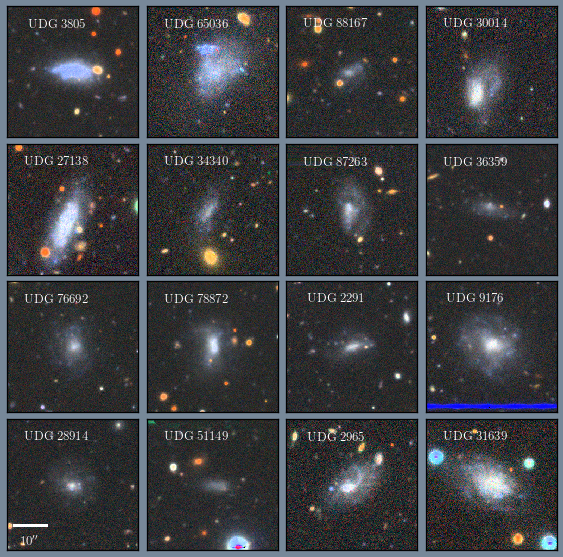

In [57]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10), facecolor='lightslategray')
#fig.patch.set_facecolor('gray')
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])

for j, lsbg in enumerate(cat):
    ax = axes[j//4, j%4]
    img = Image.open(DIR + f"{lsbg['viz-id']}.png")
    data = np.array(img.convert('L'))
    flip_img = img.transpose(Image.FLIP_TOP_BOTTOM)
    ax.imshow(flip_img, origin='lower')
    img.close()
    if j == 12:
        ax = add_scale_bar(data, ax, 0.168, None,
                          scale_bar_y_offset=0.17, scale_bar_fontsize=13, scale_bar_length=10)
#     if j == 0:
#         ax = add_text_survey(data, ax, [0.7, 0.8], survey[k], text_fontsize=16)
#     if k == 1:
#         ax = add_text_survey(data, ax, [0.5, 0.1], r'}z=\mathrm{' + ("%03.2f" % obj['z_best']), 
#                       text_fontsize=16)
#     if j == 0:
    ax = add_text(data, ax, [0.38, 0.84], f'UDG\ {lsbg["viz-id"]}', text_fontsize=13)
            
plt.subplots_adjust(hspace=0.05, wspace=0.0)
fig.savefig(DIR + 'sample_cutout.png', dpi=120, bbox_inches='tight', facecolor='lightslategray')

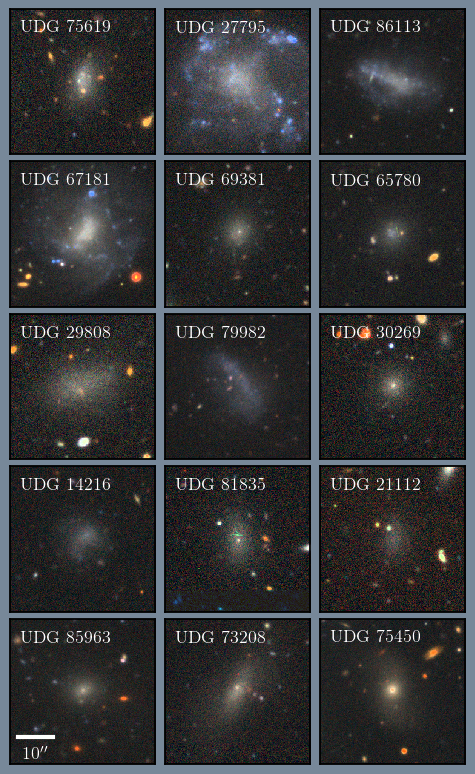

In [121]:
fig, axes = plt.subplots(5, 3, figsize=(6, 10), facecolor='lightslategray')
#fig.patch.set_facecolor('gray')
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])

for j, lsbg in enumerate(cat):
    ax = axes[j//3, j%3]
    img = Image.open(DIR + f"{lsbg['viz-id']}.png")
    data = np.array(img.convert('L'))
    flip_img = img.transpose(Image.FLIP_TOP_BOTTOM)
    ax.imshow(flip_img, origin='lower')
    img.close()
    if j == 12:
        ax = add_scale_bar(data, ax, 0.168, None,
                          scale_bar_y_offset=0.17, scale_bar_fontsize=13, scale_bar_length=10)
#     if j == 0:
#         ax = add_text_survey(data, ax, [0.7, 0.8], survey[k], text_fontsize=16)
#     if k == 1:
#         ax = add_text_survey(data, ax, [0.5, 0.1], r'}z=\mathrm{' + ("%03.2f" % obj['z_best']), 
#                       text_fontsize=16)
#     if j == 0:
    ax = add_text(data, ax, [0.38, 0.84], f'UDG\ {lsbg["viz-id"]}', text_fontsize=13)
            
plt.subplots_adjust(hspace=0.05, wspace=0.0)
fig.savefig(DIR + 'sample_cutout.png', dpi=120, bbox_inches='tight', facecolor='lightslategray')

### For Meng's sample

In [12]:
meng_cat = cat[np.in1d(cat['viz-id'], np.array([75619, 69381, 65780, 29808, 30269]))]

In [13]:
meng_cat

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC,cutout_size,prefix,radius,image_flag [5],psf_flag [5],ID,flux [4],mag [4],flux_circ [4],flux_ellip [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],SB_eff_avg [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,rhalf_circularized,rhalf_spergel,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic,abs_mag [4],SB_eff_avg_g,rhalf_circularized_phys,log_m_star,RA,DEC,dist_to_host_rvir
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,,,arcmin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes66,float64,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
16.8497991,-0.6801767,26.261,19.54,81.46,0.256,19.1249,18.5118,18.1349,6.512856000000001,7.458108,24.486990124953035,23.825105739186924,1.058973012472167,0.7741106854512696,0.5069379635138274,0.14847788106135545,0.1052158445751826,0.07508856651262487,9237,"1,4",-1,75619,2,0,0,0,0,0,2,2,0,J010709.16-003718.2,0.01770278625190258,76.66627716215355,10.693181365260706,12.275172233581543,322.38221593624473,0.2409291494811206,0.22420202254156057,28.0,0,1.0,0.0,16.78818385473689,-0.6217567854398885,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/z001_002/nsa_75619,1.0,True .. True,True .. True,75619,1232.5649725631129 .. 3049.188445371939,19.272975445883603 .. 18.289539336547875,1207.4778331643079 .. 2987.1264711271256,1207.2896835607876 .. 2986.661016072158,23.724984655193683 .. 22.741548545857952,25.249900711798755 .. 24.266464602463024,25.203125090454463 .. 24.219688981118736,24.565291468880446 .. 23.58185535954472,356.5690002321794,358.26788326488764,356.60066347210386,358.2232967668939,0.279950908201296,0.2799498902209827,1.2647489515070987,1.2647522212569005,27.17612460751825,31.550650789993703,26.77254654404421,27.16839536895909,13.587246918960657,26.93697121595497,46.645723542956425,0.48114546897151267,-1.7731787724627914,-0.3495170392742981,-0.09713783509053048,2.678401830805181,0.0014347749180925486,0.004892869900281523,0.6943944083280187,0.009277369460089845,0.9194696776038419,32.637438211326106,0.32718239582152503,1.2910243997359698,356.4900564805105,358.31338804812924,0.14795128951717532,0.0,0.0,-15.150046428426238 .. -16.133482537761964,24.565291468880446,1.6964931255446856,8.26494871128988,16.8497991,-0.6801767,0.35240590750042766
29.1199043,-4.5306946,26.116,20.0,60.83,0.234,19.6724,19.0628,18.8237,6.057156000000001,5.981892,25.00180437212442,24.15262337430638,1.0534553025669193,0.8344305771055017,0.5975449334376636,0.07054621039919277,0.04999114383685452,0.03567678750469539,8762,"7,0",-1,69381,2,0,0,0,0,0,2,2,0,J015621.79-042804.0,0.017732294276356697,76.79131136441727,10.907615035304651,12.728920936584473,456.6811110642876,0.34074036484369563,0.22383695532070902,nan,1,nan,nan,29.09086689719945

In [19]:
DIR = '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/fig/'

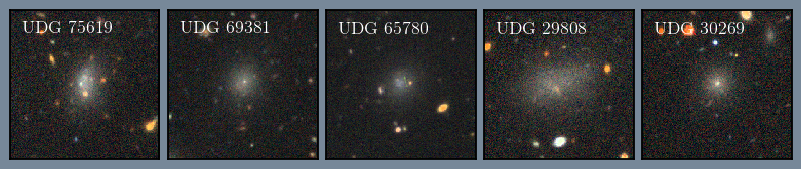

In [26]:
fig, axes = plt.subplots(1, 5, figsize=(10.2, 1.98), facecolor='lightslategray')
#fig.patch.set_facecolor('gray')
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])

for j, lsbg in enumerate(meng_cat):
    ax = axes[j]
    img = Image.open(DIR + f"{lsbg['viz-id']}.png")
    data = np.array(img.convert('L'))
    flip_img = img.transpose(Image.FLIP_TOP_BOTTOM)
    ax.imshow(flip_img, origin='lower')
    img.close()
    if j == 12:
        ax = add_scale_bar(data, ax, 0.168, None,
                          scale_bar_y_offset=0.17, scale_bar_fontsize=13, scale_bar_length=10)
#     if j == 0:
#         ax = add_text_survey(data, ax, [0.7, 0.8], survey[k], text_fontsize=16)
#     if k == 1:
#         ax = add_text_survey(data, ax, [0.5, 0.1], r'}z=\mathrm{' + ("%03.2f" % obj['z_best']), 
#                       text_fontsize=16)
#     if j == 0:
    ax = add_text(data, ax, [0.38, 0.84], f'UDG\ {lsbg["viz-id"]}', text_fontsize=13)
            
plt.subplots_adjust(hspace=0.05, wspace=0.0)
fig.savefig(DIR + 'meng_sample_cutout.png', dpi=120, bbox_inches='tight', facecolor='lightslategray')